## Norms and Robust Inversion

We use the linear regression problem to illustrate the role of norms and how to achieve a robust inversion that is less prone to outliers.

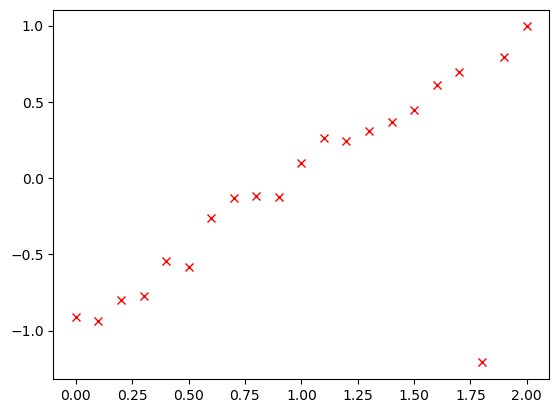

In [10]:
using PyPlot
x = (0:0.1:2.0)*1.0
A = ones(length(x), 2)
A[:, 1] = x[:]
error = 0.1
d = A * [1;-1] + randn(length(x)) * error
# We create an outlier far off the curve
d[end-2] = d[end-2] - 2.0
plot(x, d, "rx");

2-element Array{Float64,1}:
  0.7617325639624866
 -0.8356083212312562

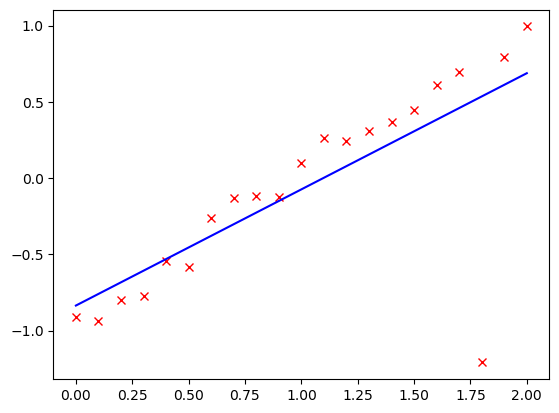

In [12]:
# We compute a model using the error-weighted least-squares
using LinearAlgebra
D = diagm(ones(length(d))*(1.0/error))
AD = D * A
ADT = transpose(AD)
m = inv(ADT*AD) * (ADT*(D*d))
display(m)
plot(x, d, "rx", x, A*m, "b-");

The points on the right half are all underestimated due to the outlier below. We would like a method that is less depending on outliers.

### The $L_p$ norm
The $L_2$ norm minimizes the sum of squared elements of a vector $\bf v$:

$$\Phi^P=\|{\bf v}\|_2=\sqrt{\sum_i v_i^2}$$

More generally, the $L_P$ norm is computed by
$$\Phi^P=\|{\bf v}\|_P=\left( \sum_i |v_i|^P \right)^{1/P}$$

In [13]:
# To use it, we create a simple function
LpNorm(r, p) = sum(abs.(r).^p)^(1.0/p);

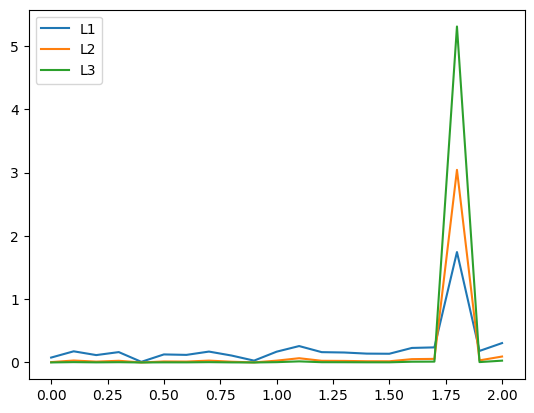

In [14]:
# We display the contributions of the residual vector
rabs = abs.(d - A * m)  #  absolute value of residual due to ^1/3
for p = 1:3
    plot(x, rabs.^p, label="L$p")
end
legend();

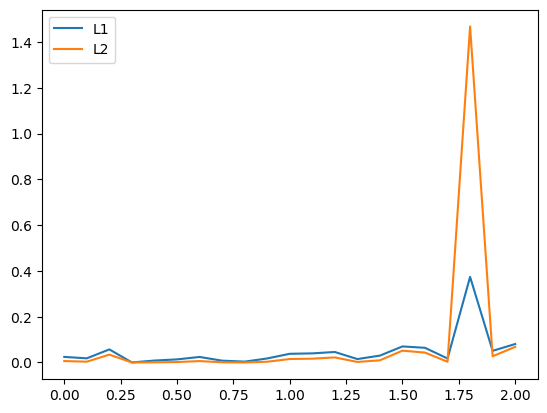

In [7]:
# We now compute the relative contribution to the norms
for p = [1, 2]
    plot(x, rabs.^p / LpNorm(r, p), label="L$p")
end
# Additionally we plot the ratio between and L1 and L2 contributions
legend();

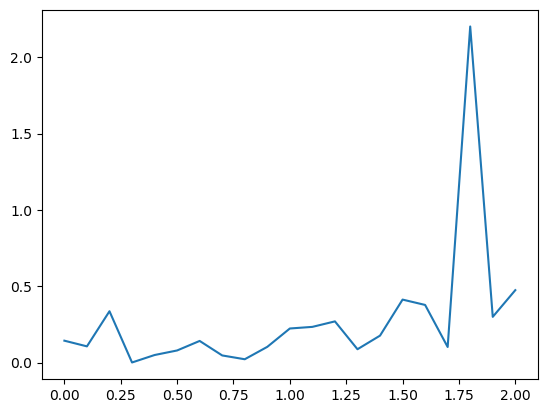

In [8]:
# We now compute the relation between the L2 and L1 contributions
ratio = (rabs.^2/sum(rabs.^2)) ./ (rabs / sum(rabs))
plot(x, ratio, label="L1/L2");

2-element Array{Float64,1}:
  0.8949650607322801
 -0.9077759236482278

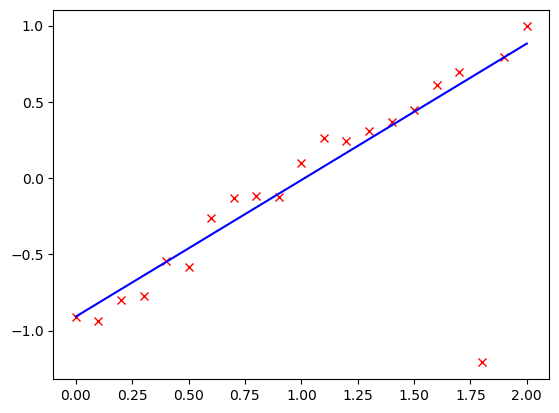

In [16]:
# We use this iteratively to re-weight the error
error = ones(length(x)) * 0.1  # equal weights
m = A \ d
for i = 1:5
    rabs = abs.(A*m-d)
    ratio = (rabs.^2/sum(rabs.^2)) ./ (rabs / sum(rabs))
    reweight = max.(ratio, 1.0)
    D = diagm(1.0./(error.*reweight))
    m = (D*A) \ (D*d)
end
display(m)
plot(x, d, "rx", x, A*m, "b-");

This procedure, referred to as **Iteratively Reweighted Least Squares (IRLS)** mimics, although using an L2 inversion, an L1 inversion and is therefore called as such. As the method is less prone to outliers, it is also called *robust inversion*.